### 1.包导入

In [1]:
import gym
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

### 2.环境尝试

In [2]:
env = gym.make("CartPole-v1")
env.reset()
env.step(0)

(array([-0.01155376, -0.22366376, -0.03782952,  0.29701212], dtype=float32),
 1.0,
 False,
 False,
 {})

### 3.定义 Actor 网络

In [3]:
# 定义策略网络
class ActorNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = T.tensor(x, dtype=T.float32).to(self.device)
        layer1 = T.relu(self.fc1(x))
        layer2 = T.relu(self.fc2(layer1))
        p = T.softmax(self.fc3(layer2), dim=-1)
        return p

### 4. 定义 Critic 网络

In [4]:
class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = T.tensor(x, dtype=T.float32).to(self.device)
        layer1 = T.relu(self.fc1(x))
        layer2 = T.relu(self.fc2(layer1))
        value = self.fc3(layer2)
        return value


### 5.设置环境和超参数

In [5]:
# 设置环境
env = gym.make("CartPole-v1")
input_dim = env.observation_space.shape[0]  # 输入维度
hidden_dim = 256
output_dim = env.action_space.n  # 输出维度
# 设置超参数
batch_size = 10  # 设置每次更新的轨迹数量
gamma = 0.9  # 奖励折扣因子
avg_episode = 50
save_episode = 200
print_episode = 50
clip_norm = 100
continue_train = True
num_episodes = 5000
learning_rate = 1e-4

# 学习进度保存路径
actor_model_path = "./save/s9_actor_net.pth"
critic_model_path = "./save/s9_critic_net.pth"
avg_path = "./save/s9_avg_rewards.pth"

In [6]:
actor_net = ActorNetwork(input_dim, hidden_dim, output_dim)
critic_net = Critic(input_dim, hidden_dim)
actor_optimizer = optim.AdamW(actor_net.parameters(), lr=learning_rate)
critic_optimizer = optim.AdamW(critic_net.parameters(), lr=learning_rate)
avg_rewards = []

if continue_train:
    if os.path.exists(actor_model_path) and os.path.exists(critic_model_path) and os.path.exists(avg_path):
        actor_net.load_state_dict(T.load(actor_model_path))
        actor_net.to(actor_net.device)
        critic_net.load_state_dict(T.load(critic_model_path))
        critic_net.to(critic_net.device)
        with open(avg_path, "rb") as f:
            avg_rewards = pickle.load(f)
len(avg_rewards)

0

### 6.开始训练

In [7]:
# 开始训练
record_rewards = []
for episode in range(1, num_episodes + 1):
    total_reward = []
    episode_reward = 0
    state = env.reset()[0]


    for _ in range(1000):# 设置最大步长
        probs = actor_net(state)
        m = Categorical(probs)
        action = m.sample()
        next_state, reward, terminated, truncated, info = env.step(action.item())

        done = bool(terminated) or bool(truncated)

        episode_reward += reward

        # Critic 估计当前状态值
        value = critic_net(state)
        next_state_value = critic_net(next_state)

        # 计算 TD 误差和优势，如果终止，则忽略下一状态
        td_target = reward + gamma * next_state_value * (1 - int(done))
        td_error = td_target - value

        # Critic 网络更新
        critic_loss = td_error.pow(2)/batch_size
        critic_loss.backward()  

        # Actor 网络更新
        actor_loss = -m.log_prob(action) * td_error.detach()/batch_size # 用detach()切断梯度,避免actor网络更新影响Critic网络更新    
        actor_loss.backward()

        if done:
            break
        else:
            state = next_state

    if episode % batch_size == 0: 
        critic_optimizer.step()
        actor_optimizer.step()
        critic_optimizer.zero_grad()
        actor_optimizer.zero_grad()


    record_rewards.append(episode_reward)

    # 输出训练进度
    if episode % avg_episode == 0:
        avg_reward = sum(record_rewards[-avg_episode:]) / avg_episode
        avg_rewards.append(avg_reward)
        if episode % print_episode == 0:
            print(
                f"Episode {episode}, Current Reward:{record_rewards[-1]}, Avg Reward: {avg_reward}"
            )
        if episode % save_episode == 0:
            print(f"to save model and avg_rewards {len(avg_rewards)}")
            T.save(actor_net.state_dict(), actor_model_path)
            T.save(critic_net.state_dict(), critic_model_path)
            with open(avg_path, "wb") as f:
                pickle.dump(avg_rewards, f)

Episode 50, Current Reward:13.0, Avg Reward: 26.14
Episode 100, Current Reward:29.0, Avg Reward: 22.22
Episode 150, Current Reward:42.0, Avg Reward: 23.64
Episode 200, Current Reward:13.0, Avg Reward: 27.92
to save model and avg_rewards 4
Episode 250, Current Reward:34.0, Avg Reward: 19.1
Episode 300, Current Reward:63.0, Avg Reward: 22.84
Episode 350, Current Reward:11.0, Avg Reward: 25.62
Episode 400, Current Reward:13.0, Avg Reward: 22.28
to save model and avg_rewards 8
Episode 450, Current Reward:18.0, Avg Reward: 20.4
Episode 500, Current Reward:11.0, Avg Reward: 20.38
Episode 550, Current Reward:47.0, Avg Reward: 18.98
Episode 600, Current Reward:61.0, Avg Reward: 21.86
to save model and avg_rewards 12
Episode 650, Current Reward:16.0, Avg Reward: 17.28
Episode 700, Current Reward:10.0, Avg Reward: 18.32
Episode 750, Current Reward:13.0, Avg Reward: 16.6
Episode 800, Current Reward:21.0, Avg Reward: 19.0
to save model and avg_rewards 16
Episode 850, Current Reward:10.0, Avg Rewar

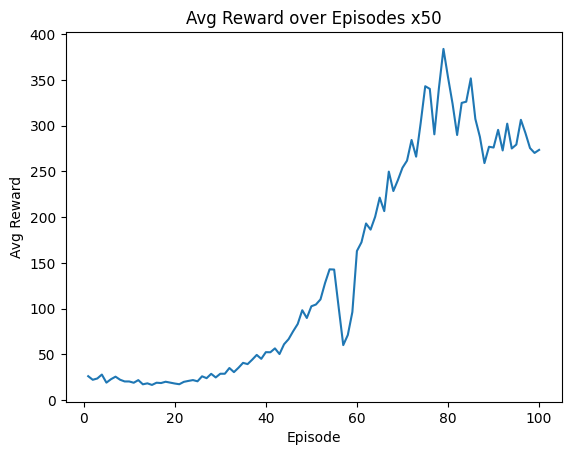

In [8]:
# 绘制得分变化图
plt.plot(range(1, len(avg_rewards) + 1), avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Avg Reward")
plt.title(f"Avg Reward over Episodes x{avg_episode}")
plt.show()